# Predicting Movie Success
#### By Zachary Szentimrey, Adesh Kadambi and Rylee Thompson

## Introduction

The purpose of this notebook is to create a model or models which can predict how successful a movie will be. We are defining success as how much money a movie makes and how many Academy Award wins/ nominations they have. The more money and awards, the greater amount of success. The models will be developped using a regression model to determine the amount of money made and a classification model for number of Oscar wins/nominations. The accuracy of these models will be found which wll be used to validate the model(s).

## Methodology and Results

In order to predict movie success, data needs to be collected in order to both create the model and test the model. IMDb website will be used to scrape movie data information pertaining to genre, actors involved and parental rating just to name a few. Additionally, a .csv database file will be used to collect Oscar wins/nomination information for actors and directors as this information is not easily accessible on IMDb. Scraping will be performed using Beautiful Soup and skikit-learn will be used to build the models.

The below libraries are used to perform data collection, database manipulation and to build the models.

In [1]:
from requests import get
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from numpy import array
from numpy import argmax
from operator import add

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import random
random.seed(a=5)

### Working with Database 

Following code access the .csv database file attached and preconditions the database in order to gather the data into dictionaries. Of all the Oscar categories that exist, the actors/actresses and director awards are considered the most important as this information is easy to scrape on IMDb. The dictionaries are based on the following categories.

- actorAwards = awards that can be recieved directly by an actor/actress
- directorAwards = awards that can be received directly by a director
- movieAwards = awards that directors and actors can directly influence

In [2]:
actorAwards = ['Actor', 'Actor in a Supporting Role', 'Actress', 'Actress in a Supporting Role', 'Actor in a Leading Role', 
               'Actress in a Leading Role']

directorAwards = ['Directing'] #For this dataset that name of the director is in the 'Film' category

movieAwards = ['Best Motion Picture', 'Outstanding Motion Picture', 'Documentary', 'Documentary (Feature)', 
               'Documentary (Short Subject)', 'Short Subject (Cartoon)', 'Short Subject (One Reel)',
               'Short Film (Animated)', 'Short Film (Live Action)', 'Best Picture', 'Animated Feature Film'] #Movie name is in the 'name' category

#Awards like writing, screenplay, production, etc are saved under other awards as the actor and director do not
#influence them as directly (or at all) as the ones above

OscarRead = pd.read_csv('OscarDatabase.csv') #read the database
yearCSV = OscarRead["Year"] #The year the movie was released
awardCSV = OscarRead["Award"] #The name of the award received/nominated for
winnerCSV = OscarRead["Winner"] #If the entry won or not

resultsCSV = winnerCSV.copy() #Create a copy to edit
resultsCSV[resultsCSV != 1] = 0 #Original CSV has a '1' for winner, and NaN for a nomination - convert NaN to '0'

nameCSV = OscarRead["Name"] 
filmCSV = OscarRead["Film"]

win = 1
nomination = 0

def getDict(awards, result = win, name = nameCSV, film = filmCSV, starAwards = True, otherAwards = False):
    
    Dict = {}
    for i in range(len(yearCSV)):
        if otherAwards == False and awardCSV[i] not in awards or resultsCSV[i] != result:
            continue
        elif otherAwards == True and awardCSV[i] in awards or resultsCSV[i] != result:
            continue
        if starAwards == False:
            try:
                try:
                    Dict[yearCSV[i] + 1][name[i]] += 1 #If the movie wins multiple awards in a year
                except:
                    Dict[yearCSV[i] + 1][name[i]] = 1 #Set the value for movie to one if the year is already in the dictionary
            except:
                Dict[yearCSV[i] + 1] = {} #if year is not in dictionary yet then create it
                Dict[yearCSV[i] + 1][name[i]] = 1 #set the value to one
                #Above code uses year + 1 for the key as the original database has the release year of the movie stored, 
                #not the year of the oscars
        else:
            try:
                try:
                    Dict[yearCSV[i] + 1][name[i]][1] += 1
                except:
                    Dict[yearCSV[i] + 1][name[i]] = film[i], 1
            except:
                Dict[yearCSV[i] + 1] = {}
                Dict[yearCSV[i] + 1][name[i]] = film[i], 1            
    return Dict

Creates a dictionary which contains Oscar wins and nominations for every Oscar that has ever been awarded (1935-2018).If a movie/actor/director wins an award, it is only saved as a winner and will not have an entry for the nomination it received for that award. Displayed from this data is the 1950 oscar winners and oscar nominees. This is to see if the databases are accurate. Additionally, the 2018 oscar winners for awards other than acting, directing and best film are listed.

In [3]:
OscarActorWinners = getDict(actorAwards)
OscarActorNoms = getDict(actorAwards, nomination)
OscarDirWinners = getDict(directorAwards, name = filmCSV, film = nameCSV)
OscarDirNoms = getDict(directorAwards, nomination, name = filmCSV, film = nameCSV)
movieWinners = getDict(movieAwards, starAwards = False)
movieNoms = getDict(movieAwards, nomination, starAwards = False)
otherAwardWinners = getDict(actorAwards + movieAwards + directorAwards, starAwards = False, otherAwards = True)
otherAwardNoms = getDict(actorAwards + movieAwards + directorAwards, nomination, starAwards = False, otherAwards = True)

print("1950 oscar winners (acting) are:", OscarActorWinners[1951])
print("1950 oscar nominees (acting) are:", OscarActorNoms[1950])


otherAwardWinners[2018]

1950 oscar winners (acting) are: {'José Ferrer': ('Cyrano de Bergerac', 1), 'George Sanders': ('All about Eve', 1), 'Judy Holliday': ('Born Yesterday', 1), 'Josephine Hull': ('Harvey', 1)}
1950 oscar nominees (acting) are: {'Kirk Douglas': ('Champion', 1), 'Gregory Peck': ("Twelve O'Clock High", 1), 'Richard Todd': ('The Hasty Heart', 1), 'John Wayne': ('Sands of Iwo Jima', 1), 'John Ireland': ("All the King's Men", 1), 'Arthur Kennedy': ('Champion', 1), 'Ralph Richardson': ('The Heiress', 1), 'James Whitmore': ('Battleground', 1), 'Jeanne Crain': ('Pinky', 1), 'Susan Hayward': ('My Foolish Heart', 1), 'Deborah Kerr': ('Edward, My Son', 1), 'Loretta Young': ('Come to the Stable', 1), 'Ethel Barrymore': ('Pinky', 1), 'Celeste Holm': ('Come to the Stable', 1), 'Elsa Lanchester': ('Come to the Stable', 1), 'Ethel Waters': ('Pinky', 1)}


{'Coco': 1,
 'The Shape of Water': 2,
 'Blade Runner 2049': 2,
 'Get Out': 1,
 'Call Me by Your Name': 1,
 'The Silent Child': 1,
 'Dunkirk': 3,
 'Dear Basketball': 1,
 'A Fantastic Woman': 1,
 'Phantom Thread': 1,
 'Darkest Hour': 1}

As seen below, Gary Oldman won an oscar for his role in Darkest Hour. This ensures the dictionary work and shows the correct results when accessing a key.

In [4]:
OscarActorWinners[2018]['Gary Oldman'][0]

'Darkest Hour'

These are the same as the dictionaries above except that for the starAwards = False tag. Using this simply returns a dictionary of the form Dict[year][actor] = oscars won in year, instead of Dict[year][actor] = movie. Simply makes it easier to deal with just the numbers.

In [5]:
OscarActorWinnersDupe = getDict(actorAwards, starAwards = False)
OscarActorNomsDupe = getDict(actorAwards, nomination, starAwards = False)
OscarDirWinnersDupe = getDict(directorAwards, name = filmCSV, film = nameCSV, starAwards = False)
OscarDirNomsDupe = getDict(directorAwards, nomination, name = filmCSV, film = nameCSV, starAwards = False)

The code below takes in the previous dictionaries and makes a nested dictionary where a running total of Oscar wins for an actor/director is recorded. This means if an actor won an award in the year 1976, the award does not count for movies in which that actor was previously in. The nested dictionary is validated by observing Anthony Quinn's oscar wins. It can be seen he had 1 Oscar in 1953 but by 1957, he had 2 OScars.

In [6]:
startYear = 1934 + 1
endYear = 2018
def getRunningTotal(Dict):

    totalDict = {}
    totalDict[startYear] = Dict[startYear]
            
    for year in range(startYear + 1, endYear + 1):
        totalDict[year] = {}
        totalDict[year].update(totalDict[year - 1]) #update dictionary with previous year to keep a running total each year
    
        for key, value in Dict[year].items():
            try:
                totalDict[year][key] += 1 #if the actor is already present increment by 1
            except:
                totalDict[year][key] = 1 #set it to 1 if not already present
    return totalDict

OscarActorWinnersTot = getRunningTotal(OscarActorWinnersDupe)
OscarActorNomsTot = getRunningTotal(OscarActorNomsDupe)
OscarDirWinnersTot = getRunningTotal(OscarDirWinnersDupe)
OscarDirNomsTot = getRunningTotal(OscarDirNomsDupe)

print(OscarActorWinnersTot[1953]['Anthony Quinn'])
print(OscarActorWinnersTot[1957]['Anthony Quinn']) #Anthony won an Oscar in 1953 and 1957
#OscarActorWinnersTot[2018]

1
2


Just for fun, a list of directors who won more than 1 award and actors who won more than 2 awards are shown below.

In [7]:
for key, value in OscarDirWinnersTot[2018].items(): #Directors that won multiple awards (just for fun lol)
    if value >= 2:
        print(key)
        print(value)
        
for key, value in OscarActorWinnersTot[2018].items(): #Actors that won multiple awards (just for fun lol)
    if value >= 3:
        print(key)
        print(value)

Frank Capra
3
John Ford
4
Leo McCarey
2
William Wyler
3
Billy Wilder
2
Elia Kazan
2
Joseph L. Mankiewicz
2
George Stevens
2
Fred Zinnemann
2
David Lean
2
Milos Forman
2
Oliver Stone
2
Clint Eastwood
2
Steven Spielberg
2
Ang Lee
2
Alejandro G. Iñárritu
2
Walter Brennan
3
Ingrid Bergman
3
Katharine Hepburn
3
Jack Nicholson
3
Meryl Streep
3


### Web Scraping

In order to get all of the features required to create the prediction model, data from movies needs to be scraped. The website that contains a lot of information on movies is IMDb. This website contains information on thousands of movies including the features below.

- name of the movie
- year the movie was made
- genre of the movie
- movie runtime
- amount of money the movie made
- Metascore
- IMDb rating
- parental/audience rating
- actors and director in the movie
- number of user votes

Below, multiple IMDb URL's are accessed in order to collect information on many movies. Each webpage contain 50 movies so this for loop creates a list of URL's where 50 movies exists on each page. 

In [8]:
urlArray = []

numMovies = 10000 #numMovies must be less than 300,908, numMovies % 50 must be 0

for i in range(1, numMovies - 48, 50): #create an array of urls to iterate through
    urlArray.append('https://www.imdb.com/search/title?title_type=feature&release_date=1935-01-01,2017-12-31&sort=boxoffice_gross_us,desc&start=' #gross
                    + str(i) + '&ref_=adv_nxt')
    urlArray.append('https://www.imdb.com/search/title?title_type=feature&release_date=1935-01-01,2017-12-31&start=' + str(i) + '&ref_=adv_nxt') #popularity
    urlArray.append('https://www.imdb.com/search/title?title_type=feature&release_date=1935-01-01,2017-12-31&sort=num_votes,desc&start=' + str(i) + '&ref_=adv_nxt') #numVotes

The function `cleandata()` is used later after collecting the information. This function turns a string of numbers into numeric values or it removes unncessary spacing. This is for the movie year, genre, runtme, box office gross and user votes.

In [9]:
def cleanData(year_, genre, runtime, box_office, votes):
    year1 = ''.join(c for c in year_ if c.isdigit()) #remove non-numeric characters from year
    
    genre1 = ''.join(c for c in genre if (c != '\n')) #original data has '\n' scattered around... remove those
    
    runtime1 = ''.join(c for c in runtime if c.isdigit()) #remove non-numeric characters from runtime
    
    box = ''.join(c for c in box_office if (c.isdigit() or c == '.')) #remove non-numeric characters, but keep the decimal
    box = round(float(box) * (10**6)) #original is in millions
    
    votes1 = ''.join(c for c in votes if c.isdigit()) #remove non-numeric characters from year
    
    
    return int(year1), genre1, int(runtime1), box, int(votes1)

The function `normalize()` is used to normalize the runtime and movie gross data to be used for the machine learning model.

In [10]:
def normalize(runtime, gross):
    nor_runtime = np.divide(runtime,max(runtime))
    nor_gross = np.divide(gross,max(gross))
    return nor_runtime, nor_gross

The `CPIdict` is a dictionary which contains multiplication values to adjust the box office gross values into today's dollar value.

In [11]:
CPIdict = {}
CPIread = pd.read_csv('CPI.csv') #CPI.csv contains the multiplication factor to get from a given year to 2019 to adjust
                                 #for inflation
for i in range(len(CPIread["Growth"] + 1)):
     CPIdict[CPIread["Year"][i]] = CPIread["To 2019"][i]
print("Movies released in 1990 have a multiplier of", CPIdict[1990], "to their gross to adjust for inflation")

Movies released in 1990 have a multiplier of 1.9345070969999998 to their gross to adjust for inflation


The function `inflationAdjust()` multiplies the gross value by the multiplication factor for the year it was released.

In [12]:
def inflationAdjust(year, box_office):
    return int(round(box_office * CPIdict[year])) 

The function `getOscarNum` is used to evaulate each movie thats is scraped to add the number of Oscar win and nominations to a movie based on the actors and director involved. This function uses the function `checkDict()` in order to accomplish this task. The function returns the nominations and wins in the following order.
1. prevStarWins
2. prevStarNoms
3. starWins
4. starNoms
5. movieWinsVal
6. movieNomsVal
7. otherWins
8. otherNoms

In [13]:
def getOscarNum(actor1, actor2, actor3, actor4, actor5, movieName, releaseYear):
    stars = []
    stars.extend([actor1, actor2, actor3, actor4, actor5])
    prevStarWins = prevStarNoms = starWins = starNoms = movieWinsVal = movieNomsVal = otherWins = otherNoms = 0
    oscarYear = releaseYear + 1
    for star in stars:
        if star != '': #Checks how many oscar nominations and wins the directors and actors have prior to this movie
            prevStarWins += checkDict(star, OscarDirWinnersTot, releaseYear) #
            prevStarWins += checkDict(star, OscarActorWinnersTot, releaseYear)
            prevStarNoms += checkDict(star, OscarDirNomsTot, releaseYear)
            prevStarNoms += checkDict(star, OscarActorNomsTot, releaseYear)
            starWins += checkDict(star, OscarDirWinners, oscarYear, movie = movieName)
            starWins += checkDict(star, OscarActorWinners, oscarYear, movie = movieName)
            starNoms += checkDict(star, OscarDirNoms, oscarYear, movie = movieName)
            starNoms += checkDict(star, OscarActorNoms, oscarYear, movie = movieName)
    #Checks num of nominations/wins this movie received
    movieWinsVal += checkDict(movieName, movieWinners, oscarYear)
    movieNomsVal += checkDict(movieName, movieNoms, oscarYear)
    otherWins += checkDict(movieName, otherAwardWinners, oscarYear)
    otherNoms += checkDict(movieName, otherAwardNoms, oscarYear)
    return prevStarWins, prevStarNoms, starWins, starNoms, movieWinsVal, movieNomsVal, otherWins, otherNoms
        
def checkDict(name, Dict, year, movie = None):
    num = 0
    movieName = []
    if movie == None:
        try:
            num += Dict[year][name]       
        except:
            pass
    else:
        try:
            movieName = Dict[year][name][0]
            if movieName == movie:
                num += 1
        except:
            pass
    return num

Below we check that the function `getOscarNum()` works using Gary Oldman. Gary won an award for his role in Darkest Hour so starWins is 1 (third number in the list).

In [14]:
x = getOscarNum('Gary Oldman', '', '', '', '', 'Darkest Hour', 2017)
x 

(0, 1, 1, 0, 0, 1, 1, 3)

Gary didn't win an award for this movie so starWins is 0 (third number in the list) which is seen below.

In [15]:
x = getOscarNum('Gary Oldman', '', '', '', '', 'not a real movie', 2017)
x 

(0, 1, 0, 0, 0, 0, 0, 0)

The backbone of the web scraping is performed in the next block of code. What this code does is it cycles through each URL that contains 50 movies and extracts the important information feature mentioned earlier. After collecting each feature, the data is cleaned using previously defined functions and appended to a list. As each movie's information is collected, if anything is missing, that movie is dropped from the list and the next movie is tried. Each movie that conatins missing data is returned to show which movie's are not acceptable to use.

Finally, once all the movies are scraped, the appended list is unzipped to create lists of all the features and information collected.

**This part of the notebook can take up to 30 minutes to perform.**

In [16]:
names = []
year = []
genres = []
runtimes = []
metascores = []
imdbRatings = []
audienceRating = []
movieGross = []
directors =[]
movieGrossInflation = []
Star1 = []
Star2 = []
Star3 = []
Star4 = []
Star5 = []
res = []
missingData = 0

for url in urlArray:
    response = get(url)
    html_soup = BeautifulSoup(response.text, 'html.parser')
    movie_cont = html_soup.find_all('div', class_ = 'lister-item mode-advanced')
    
    for movie in movie_cont:
        try:
            name = movie.h3.a.text
            if name in names:
                raise error
        except:
            continue
        try:
            if name in names:
                raise ValueError
            year_ = movie.h3.find('span', class_ = 'lister-item-year text-muted unbold').text
            genre = movie.p.find('span', class_ = 'genre').text
            runtime = movie.p.find('span', class_ = 'runtime').text
            viewer_rating = movie.p.span.text
            if viewer_rating == runtime:
                raise Error
            m_score = movie.find('span', class_ = 'metascore').text
            imdb_rating = float(movie.strong.text)
            box_office = movie.find_all('span', attrs = {'name': 'nv'})[1].text
            votes = movie.find_all('span', attrs = {'name': 'nv'})[0].text
            people = movie.find_all('p', class_ = '')[1]
            people = people.find_all('a')
            director = people[0].text
            actor1 = people[1].text
            
            #This try/except block is just in case lesser known movies are missing actors (might happen when
            #numMovies is set to like 10000, and I don't think it's a big deal as long as we have one actor + director)
            try:
                actor2 = people[2].text
            except:
                actor2 = ''
            try:
                actor3 = people[3].text
            except:
                actor3 = ''
            try:
                actor4 = people[4].text
            except:
                actor4 = ''
            try:
                actor5 = people[5].text
            except:
                actor5 =''
            
            year_, genre, runtime, box_office, votes = cleanData(year_, genre, runtime, box_office, votes) #clean up data
            
            box_office_inflation = inflationAdjust(year_, box_office) #adjust for inflation
            
            numStarWins, numStarNoms, starWin, starNom, numMovieWins, numMovieNoms, numOtherWins, numOtherNoms = getOscarNum(actor1, actor2, actor3, actor4, actor5, name, year_)
                
            res.append((name, year_, genre, runtime, director, actor1, actor2, actor3, actor4, actor5,
                        viewer_rating, m_score, imdb_rating, votes, box_office, box_office_inflation, numStarWins, 
                        numStarNoms, starWin, starNom, numMovieWins, numMovieNoms, numOtherWins, numOtherNoms))
        except:
            print("Missing data for:", name)
            missingData += 1
            
(names, year, genres, runtimes, directors, Star1, Star2, Star3, Star4, Star5, audienceRatings, metascores, 
imdbRatings, numVotes, movieGross, movieGrossInflation, starWinsList, starNomsList, starWon, starNom, movieWinsList, movieNomsList, 
otherWinsList, otherNomsList) = zip(*res)

Missing data for: Unicorn Store
Missing data for: Love
Missing data for: Troop Beverly Hills
Missing data for: Lifeforce
Missing data for: Bone Tomahawk
Missing data for: A Clockwork Orange
Missing data for: A Clockwork Orange
Missing data for: Summer of '42
Missing data for: Contratiempo
Missing data for: To Kill a Mockingbird
Missing data for: Brawl in Cell Block 99
Missing data for: Inherit the Wind
Missing data for: Death Proof
Missing data for: Burn Out
Missing data for: Exposed
Missing data for: Home Alone 2: Lost in New York
Missing data for: 3 Men and a Baby
Missing data for: Così fan tutte
Missing data for: Gerald's Game
Missing data for: Martyrs
Missing data for: The Craft
Missing data for: Caligola
Missing data for: A Star Is Born
Missing data for: Bright
Missing data for: Dead Poets Society
Missing data for: It's a Wonderful Life
Missing data for: One Hundred and One Dalmatians
Missing data for: Look Who's Talking
Missing data for: 101 Dalmatians
Missing data for: Habitació

Missing data for: Beaches
Missing data for: The Do-Over
Missing data for: This Is England
Missing data for: Sneakers
Missing data for: DragonHeart
Missing data for: Dennis the Menace
Missing data for: Broadcast News
Missing data for: Up Close & Personal
Missing data for: Something to Talk About
Missing data for: A Bridge Too Far
Missing data for: Dick Tracy
Missing data for: La montaña sagrada
Missing data for: Hocus Pocus
Missing data for: Stratton
Missing data for: The Riot Club
Missing data for: Dangerous Liaisons
Missing data for: Batoru rowaiaru
Missing data for: Akira
Missing data for: Idi i smotri
Missing data for: Escape from Alcatraz
Missing data for: The Meaning of Life
Missing data for: Judge Dredd
Missing data for: The Four Seasons
Missing data for: Sommersby
Missing data for: When a Man Loves a Woman
Missing data for: Legal Eagles
Missing data for: Homeward Bound II: Lost in San Francisco
Missing data for: Hotaru no haka
Missing data for: It's a Mad Mad Mad Mad World
Missi

Missing data for: The Night of the Hunter
Missing data for: The Autopsy of Jane Doe
Missing data for: Swades: We, the People
Missing data for: Martyrs
Missing data for: Trick 'r Treat
Missing data for: Paris, Texas
Missing data for: The Big Sleep
Missing data for: Silent Movie
Missing data for: Set It Off
Missing data for: The Robe
Missing data for: The Greatest Show on Earth
Missing data for: Taps
Missing data for: Summer School
Missing data for: Silkwood
Missing data for: Sharky's Machine
Missing data for: Leviatán
Missing data for: Dog Soldiers
Missing data for: Charlie, the Lonesome Cougar
Missing data for: Return to Oz
Missing data for: Soldier
Missing data for: Aftermath
Missing data for: Lie with Me
Missing data for: Little Evil
Missing data for: [Rec]
Missing data for: Persona
Missing data for: The Killing
Missing data for: The Searchers
Missing data for: Assassins
Missing data for: Look Who's Talking
Missing data for: Reis
Missing data for: The Day the Earth Stood Still
Missin

Missing data for: The Awakening
Missing data for: Dangerous Liaisons
Missing data for: Charade
Missing data for: Beethoven
Missing data for: Abre los ojos
Missing data for: The Gods Must Be Crazy
Missing data for: Airport '77
Missing data for: Rollerball
Missing data for: Spartacus
Missing data for: White Christmas
Missing data for: Neighbors
Missing data for: Green Card
Missing data for: Serpico
Missing data for: Madeline
Missing data for: Harry and the Hendersons
Missing data for: Never Cry Wolf
Missing data for: Tora! Tora! Tora!
Missing data for: A Low Down Dirty Shame
Missing data for: Pacific Heights
Missing data for: Easy Money
Missing data for: Shoot to Kill
Missing data for: Fort Apache the Bronx
Missing data for: The Rose
Missing data for: Rebecca
Missing data for: Harry and the Hendersons
Missing data for: Short Circuit
Missing data for: Get the Gringo
Missing data for: The Big Green
Missing data for: Guys and Dolls
Missing data for: The Hand That Rocks the Cradle
Missing da

Missing data for: 8½
Missing data for: Black Sheep
Missing data for: Up the Creek
Missing data for: Love Potion No. 9
Missing data for: Detour
Missing data for: Daylight
Missing data for: Dag II
Missing data for: The Searchers
Missing data for: Playing It Cool
Missing data for: A Girl Walks Home Alone at Night
Missing data for: The Shootist
Missing data for: Antfarm Dickhole
Missing data for: You'll Find Out
Missing data for: Let It Ride
Missing data for: Brief Encounter
Missing data for: Blowup
Missing data for: Cry-Baby
Missing data for: Janghwa, Hongryeon
Missing data for: Crimes and Misdemeanors
Missing data for: Last Man Standing
Missing data for: Young Guns
Missing data for: Harvey
Missing data for: Murder on the Orient Express
Missing data for: G.O.R.A.
Missing data for: Sex, Lies, and Videotape
Missing data for: Gorillas in the Mist: The Story of Dian Fossey
Missing data for: Ghost Dad
Missing data for: Operation Dumbo Drop
Missing data for: The Other Side of Midnight
Missing d

Missing data for: Rhinestone
Missing data for: Quigley Down Under
Missing data for: Raising Cain
Missing data for: The Bells of St. Mary's
Missing data for: Straight Talk
Missing data for: Mister Roberts
Missing data for: Kuffs
Missing data for: Tales from the Crypt: Demon Knight
Missing data for: Weekend Pass
Missing data for: The Wiz
Missing data for: Madhouse
Missing data for: Punchline
Missing data for: The Air Up There
Missing data for: Iron Will
Missing data for: Emelie
Missing data for: The Beastmaster
Missing data for: Troll
Missing data for: Singles
Missing data for: Daylight's End
Missing data for: Heist
Missing data for: The Ottoman Lieutenant
Missing data for: Rio Bravo
Missing data for: The Chase
Missing data for: Mektoub, My Love: Canto Uno
Missing data for: Home Alone 3
Missing data for: Harold and Maude
Missing data for: Rashômon
Missing data for: The Wiz
Missing data for: The Whole Truth
Missing data for: Sister Act 2: Back in the Habit
Missing data for: The Rebound
Mi

Missing data for: Year of the Dragon
Missing data for: Her Alibi
Missing data for: Casualties of War
Missing data for: Windwalker
Missing data for: Geronimo: An American Legend
Missing data for: Paradise
Missing data for: The Boatniks
Missing data for: The Apartment
Missing data for: Vice
Missing data for: The Way We Were
Missing data for: Pride
Missing data for: Hercules in New York
Missing data for: Belle de jour
Missing data for: Deathstalker
Missing data for: Maniac Cop
Missing data for: Victory
Missing data for: 3 Men and a Baby
Missing data for: Westward the Women
Missing data for: House of Wax
Missing data for: Who's Afraid of Virginia Woolf?
Missing data for: Imperium
Missing data for: Action U.S.A.
Missing data for: I Spit on Your Grave 3: Vengeance Is Mine
Missing data for: Time Trap
Missing data for: The People Under the Stairs
Missing data for: Careful What You Wish For
Missing data for: Hoosiers
Missing data for: Ladyhawke
Missing data for: From Here to Eternity
Missing da

Missing data for: Looking for Mr. Goodbar
Missing data for: Zapped!
Missing data for: They Call Me Bruce?
Missing data for: Death Warrant
Missing data for: Lightning Jack
Missing data for: Andre
Missing data for: Oliver!
Missing data for: Blink
Missing data for: Baby's Day Out
Missing data for: Deep Cover
Missing data for: Muppets from Space
Missing data for: Beat Street
Missing data for: Heart and Souls
Missing data for: The War
Missing data for: Terminal Velocity
Missing data for: Spacehunter: Adventures in the Forbidden Zone
Missing data for: BUtterfield 8
Missing data for: Sergeant York
Missing data for: Defending Your Life
Missing data for: Monkey Trouble
Missing data for: Burglar
Missing data for: That Old Feeling
Missing data for: Teenage Cocktail
Missing data for: The Man Who Knew Too Little
Missing data for: 633 Squadron
Missing data for: Zulu
Missing data for: Darbareye Elly
Missing data for: Johnny Mnemonic
Missing data for: Goon: Last of the Enforcers
Missing data for: Carn

Missing data for: The Lodgers
Missing data for: Around the World in 80 Days
Missing data for: Blitz
Missing data for: Monamour
Missing data for: Holding the Man
Missing data for: Greystoke: The Legend of Tarzan, Lord of the Apes
Missing data for: Holidays
Missing data for: The Time Machine
Missing data for: Love and Death
Missing data for: Redirected
Missing data for: Tesis
Missing data for: The Physician
Missing data for: The Butterfly Effect 2
Missing data for: Bandidas
Missing data for: Before I Wake
Missing data for: Would You Rather
Missing data for: Fantasia 2000
Missing data for: The Verdict
Missing data for: The Adventures of Pinocchio
Missing data for: Fire Birds
Missing data for: The Substitute
Missing data for: My Left Foot: The Story of Christy Brown
Missing data for: The Sixth Man
Missing data for: Kickboxer
Missing data for: City of Joy
Missing data for: Arthur 2: On the Rocks
Missing data for: The Nude Bomb
Missing data for: Educating Rita
Missing data for: That Touch of

Missing data for: The Sons of Katie Elder
Missing data for: What a Way to Go!
Missing data for: Lord of Illusions
Missing data for: Body of Evidence
Missing data for: Class Act
Missing data for: Visiting Hours
Missing data for: Roller Boogie
Missing data for: Vice Squad
Missing data for: Koneko monogatari
Missing data for: Crazy People
Missing data for: The Unsinkable Molly Brown
Missing data for: Greedy
Missing data for: Bye Bye Birdie
Missing data for: Author! Author!
Missing data for: Back to the Beach
Missing data for: The Evil That Men Do
Missing data for: A Boy Named Charlie Brown
Missing data for: Ghosts of Mississippi
Missing data for: The Philadelphia Story
Missing data for: The Humanity Bureau
Missing data for: The NeverEnding Story II: The Next Chapter
Missing data for: Giù la testa
Missing data for: Backcountry
Missing data for: Brain Damage
Missing data for: Baby's Day Out
Missing data for: Tom Horn
Missing data for: Funny Girl
Missing data for: Zombi 2
Missing data for: T

Missing data for: Black Christmas
Missing data for: Fitzcarraldo
Missing data for: Brighton Beach Memoirs
Missing data for: The King and I
Missing data for: Deathstalker
Missing data for: Anatomy of a Murder
Missing data for: Making Love
Missing data for: Firewalker
Missing data for: Moulin Rouge
Missing data for: Back Roads
Missing data for: Yankee Doodle Dandy
Missing data for: Zelig
Missing data for: Tales from the Hood
Missing data for: The Lords of Discipline
Missing data for: Gunfight at the O.K. Corral
Missing data for: Up the Creek
Missing data for: Rock-A-Doodle
Missing data for: Far from Home: The Adventures of Yellow Dog
Missing data for: Gross Anatomy
Missing data for: Lifeforce
Missing data for: Finian's Rainbow
Missing data for: So I Married an Axe Murderer
Missing data for: Henry & June
Missing data for: Police Academy 6: City Under Siege
Missing data for: Infinity Chamber
Missing data for: The Case of the Velvet Claws
Missing data for: Our Souls at Night
Missing data fo

Missing data for: Lavender
Missing data for: Three
Missing data for: Alone in Berlin
Missing data for: The Vikings
Missing data for: Plan 9 from Outer Space
Missing data for: Riaru onigokko
Missing data for: Screwballs
Missing data for: A Lonely Place to Die
Missing data for: What Just Happened
Missing data for: Open Grave
Missing data for: To Wong Foo Thanks for Everything, Julie Newmar
Missing data for: Red River
Missing data for: On Golden Pond
Missing data for: Rogue
Missing data for: Weekend
Missing data for: Memphis Belle
Missing data for: Dragon: The Bruce Lee Story
Missing data for: Talvar
Missing data for: Air America
Missing data for: Da hong deng long gao gao gua
Missing data for: Mutant Chronicles
Missing data for: Dabangg
Missing data for: Casino Royale
Missing data for: Victory
Missing data for: Sophie Scholl - Die letzten Tage
Missing data for: Tais-toi!
Missing data for: Husbands and Wives
Missing data for: Husbands and Wives
Missing data for: We're No Angels
Missing da

Missing data for: S. Darko
Missing data for: The Rewrite
Missing data for: Embrace of the Vampire
Missing data for: A Perfect Day
Missing data for: Soul Man
Missing data for: The Lost Empire
Missing data for: The Taking of Pelham One Two Three
Missing data for: Day of the Woman
Missing data for: Fire with Fire
Missing data for: My Stepmother Is an Alien
Missing data for: Funny Face
Missing data for: The Grifters
Missing data for: Jungfrukällan
Missing data for: Dead End
Missing data for: Tengoku to jigoku
Missing data for: The Rookie
Missing data for: The Innocents
Missing data for: The Siege of Jadotville
Missing data for: Cross of Iron
Missing data for: Vivre sa vie: Film en douze tableaux
Missing data for: Baazigar
Missing data for: Speak
Missing data for: The Lady from Shanghai
Missing data for: Gongdong gyeongbi guyeok JSA
Missing data for: Frontière(s)
Missing data for: Beethoven's 2nd
Missing data for: Little Giants
Missing data for: Screamers
Missing data for: DuckTales the Mov

Missing data for: Whatever It Takes
Missing data for: The Awakening
Missing data for: Dr. Giggles
Missing data for: Twice in a Lifetime
Missing data for: Something Wicked This Way Comes
Missing data for: Mitt liv som hund
Missing data for: The Postman Always Rings Twice
Missing data for: Lipstick
Missing data for: Mr. Jones
Missing data for: Reckless
Missing data for: The Love Letter
Missing data for: Cry-Baby
Missing data for: Satisfaction
Missing data for: Christopher Columbus: The Discovery
Missing data for: The Blob
Missing data for: Tall Tale
Missing data for: Black Robe
Missing data for: Whose Life Is It Anyway?
Missing data for: Bajrangi Bhaijaan
Missing data for: Witness for the Prosecution
Missing data for: Holiday Inn
Missing data for: Nick of Time
Missing data for: Cheetah
Missing data for: DeepStar Six
Missing data for: Funny About Love
Missing data for: The Childhood of a Leader
Missing data for: Sneakers
Missing data for: Double Impact
Missing data for: Leprechaun: Origin

Missing data for: The Man from Snowy River
Missing data for: Lucifer
Missing data for: Malone
Missing data for: Devil's Gate
Missing data for: Kurenai no buta
Missing data for: Atoll K
Missing data for: One-Eyed Jacks
Missing data for: Nothing But Trouble
Missing data for: Walkabout
Missing data for: The Dyatlov Pass Incident
Missing data for: 3 Men and a Little Lady
Missing data for: Horsemen
Missing data for: One Eight Seven
Missing data for: Tasogare Seibei
Missing data for: Pete's Dragon
Missing data for: Død snø 2
Missing data for: Jessabelle
Missing data for: Die Blechtrommel
Missing data for: Phenomena
Missing data for: St. Trinian's
Missing data for: Darr
Missing data for: The Big Heat
Missing data for: Rollerball
Missing data for: American Mary
Missing data for: Agneepath
Missing data for: Ink
Missing data for: Habitación en Roma
Missing data for: Les parapluies de Cherbourg
Missing data for: Roma città aperta
Missing data for: Great Expectations
Missing data for: The Crucible

Missing data for: Delta Force 2: The Colombian Connection
Missing data for: Hairspray
Missing data for: Nightmares
Missing data for: Six Weeks
Missing data for: The Golden Seal
Missing data for: Forced Vengeance
Missing data for: Where the Buffalo Roam
Missing data for: Swing Shift
Missing data for: Fresh Horses
Missing data for: Black Moon Rising
Missing data for: The Gong Show Movie
Missing data for: The Hunted
Missing data for: Best of the Best II
Missing data for: Here Come the Littles
Missing data for: Bajirao Mastani
Missing data for: The Razor's Edge
Missing data for: Savage Sam
Missing data for: The Last Sunset
Missing data for: Let's Make Love
Missing data for: The Big Sleep
Missing data for: The Road to Wellville
Missing data for: The Wild Angels
Missing data for: Flashback
Missing data for: The Osterman Weekend
Missing data for: Switchback
Missing data for: The Real McCoy
Missing data for: The Broken Circle Breakdown
Missing data for: Ikiru
Missing data for: Kagemusha
Missin

Missing data for: La isla mínima
Missing data for: Irreconcilable Differences
Missing data for: The Secret of Moonacre
Missing data for: Masaan
Missing data for: Les rivières pourpres 2 - Les anges de l'apocalypse
Missing data for: Bunraku
Missing data for: Hairspray
Missing data for: Angels with Dirty Faces
Missing data for: The Beastmaster
Missing data for: Europa
Missing data for: Meet Me in St. Louis
Missing data for: The Numbers Station
Missing data for: Ocean's Eleven
Missing data for: Neerja
Missing data for: Un monstre à Paris
Missing data for: Only You
Missing data for: Cet obscur objet du désir
Missing data for: Her Sey Çok Güzel Olacak
Missing data for: Dügün Dernek
Missing data for: Vikram Vedha
Missing data for: Copie conforme
Missing data for: Ascenseur pour l'échafaud
Missing data for: Last Dance
Missing data for: The Rescue
Missing data for: The Transformers: The Movie
Missing data for: Crossroads
Missing data for: Stanley & Iris
Missing data for: Mona Lisa
Missing data

Missing data for: Ba wang bie ji
Missing data for: Inchon
Missing data for: Jane Eyre
Missing data for: The Comedians
Missing data for: The Yearling
Missing data for: Clara's Heart
Missing data for: 52 Pick-Up
Missing data for: Moonlight: Unfortunately a Love Story
Missing data for: Jack the Bear
Missing data for: Butch and Sundance: The Early Days
Missing data for: Heidi's Song
Missing data for: They Call Me Mister Tibbs!
Missing data for: Of Mice and Men
Missing data for: The Hotel New Hampshire
Missing data for: Out of Bounds
Missing data for: Top Dog
Missing data for: Ghost in the Machine
Missing data for: Dangerous Ground
Missing data for: American Dreamer
Missing data for: The Diary of Anne Frank
Missing data for: Brass Target
Missing data for: Tempest
Missing data for: Perfectos desconocidos
Missing data for: Treasure Island
Missing data for: Darby O'Gill and the Little People
Missing data for: Out of the Past
Missing data for: Arn: Tempelriddaren
Missing data for: Waiting to Ex

Missing data for: Very Good Girls
Missing data for: Hickok
Missing data for: Gigi
Missing data for: The Asphalt Jungle
Missing data for: Alligator
Missing data for: Tourist Trap
Missing data for: We're Back! A Dinosaur's Story
Missing data for: Point of No Return
Missing data for: A Moment in the Reeds
Missing data for: Feuchtgebiete
Missing data for: Seppuku
Missing data for: The Narrow Margin
Missing data for: Dreamscape
Missing data for: Stay Hungry
Missing data for: Do lok tin si
Missing data for: Hick
Missing data for: Bareilly Ki Barfi
Missing data for: Il Decameron
Missing data for: Poliziotto superpiù
Missing data for: Bienvenue à Marly-Gomont
Missing data for: Ironclad
Missing data for: Four Sisters and a Wedding
Missing data for: Imitation of Life
Missing data for: Trespass Against Us
Missing data for: Lady Bloodfight
Missing data for: La piscine
Missing data for: Shadowlands
Missing data for: Moonwalkers
Missing data for: Eskiya
Missing data for: Neko no ongaeshi
Missing dat

Missing data for: Haunter
Missing data for: Carrie Pilby
Missing data for: The Survivalist
Missing data for: Flaskepost fra P
Missing data for: Army of One
Missing data for: Avouterie
Missing data for: Last Shift
Missing data for: Hamburger Hill
Missing data for: Pit and the Pendulum
Missing data for: The Killer Elite
Missing data for: Miss Bala
Missing data for: Visions
Missing data for: Madeline
Missing data for: Sudden Death
Missing data for: Les diaboliques
Missing data for: Mandingo
Missing data for: Dèmoni
Missing data for: Infini
Missing data for: Meet the Feebles
Missing data for: Zui quan
Missing data for: Princess Cyd
Missing data for: The Mechanic
Missing data for: On Dangerous Ground
Missing data for: Twins of Evil
Missing data for: Laura
Missing data for: The Thinning
Missing data for: Journey to the Center of the Earth
Missing data for: The Long Good Friday
Missing data for: The Ox-Bow Incident
Missing data for: Evil Toons
Missing data for: Flash Gordon
Missing data for: 

Missing data for: My Heroes Have Always Been Cowboys
Missing data for: Bug
Missing data for: The Pest
Missing data for: The Bride
Missing data for: Night and the City
Missing data for: A la mala
Missing data for: Om Shanti Om
Missing data for: Turk 182
Missing data for: Dead Heat
Missing data for: Everyone Says I Love You
Missing data for: The Mighty
Missing data for: Dark Blood
Missing data for: Hobgoblins
Missing data for: Danur: I Can See Ghosts
Missing data for: Ahí va el diablo
Missing data for: I Was an American Spy
Missing data for: Hounds of Love
Missing data for: Going Overboard
Missing data for: Sleepaway Camp II: Unhappy Campers
Missing data for: The Slut
Missing data for: The Taking of Pelham One Two Three
Missing data for: Zipper
Missing data for: Amazon Women on the Moon
Missing data for: The Red Shoes
Missing data for: The Sentinel
Missing data for: Bad Boy Bubby
Missing data for: #REALITYHIGH
Missing data for: Nona
Missing data for: Che: Part One
Missing data for: Young

Missing data for: Race for Your Life, Charlie Brown
Missing data for: Lost and Found
Missing data for: Barfly
Missing data for: Traces of Red
Missing data for: A Place in the Sun
Missing data for: So Undercover
Missing data for: Pola X
Missing data for: Vendetta
Missing data for: School Spirit
Missing data for: Transylvania 6-5000
Missing data for: The Trust
Missing data for: Dragon: The Bruce Lee Story
Missing data for: Malibu Express
Missing data for: Jeruzalem
Missing data for: Breeders
Missing data for: Premature
Missing data for: Tengo ganas de ti
Missing data for: The Four Seasons
Missing data for: Close My Eyes
Missing data for: The Swimmer
Missing data for: Tony Rome
Missing data for: Solarbabies
Missing data for: Passport to Pimlico
Missing data for: Birkebeinerne
Missing data for: Batman and Harley Quinn
Missing data for: Wild America
Missing data for: Seven Sundays
Missing data for: Red Scorpion
Missing data for: Southern Comfort
Missing data for: Class of 1999
Missing data 

Missing data for: Dying Young
Missing data for: The Good Neighbor
Missing data for: Aile Arasinda
Missing data for: Five Minarets in New York
Missing data for: Pillow Talk
Missing data for: Evangerion shin gekijôban: Ha
Missing data for: Café de Flore
Missing data for: Gridlock'd
Missing data for: The Cincinnati Kid
Missing data for: Blue Mountain State: The Rise of Thadland
Missing data for: The Jungle Book 2
Missing data for: Oh Boy
Missing data for: Warlock
Missing data for: Le prénom
Missing data for: Extraterrestrial
Missing data for: Baghban
Missing data for: Children of a Lesser God
Missing data for: Nordwand
Missing data for: Convoy
Missing data for: Thani Oruvan
Missing data for: Kolja
Missing data for: The Mirror Has Two Faces
Missing data for: The Company of Wolves
Missing data for: High Sierra
Missing data for: Flight 7500
Missing data for: The Scarlet Letter
Missing data for: Il mondo di Yor
Missing data for: Return to the Blue Lagoon
Missing data for: Loving Couples
Missi

Missing data for: On the Riviera
Missing data for: Two Guys from Milwaukee
Missing data for: Behind Enemy Lines
Missing data for: Desert Hearts
Missing data for: Choose Me
Missing data for: Moonlight and Valentino
Missing data for: The Stepfather
Missing data for: Kiss and Cry
Missing data for: The Goodbye Girl
Missing data for: Baby
Missing data for: My Darling Clementine
Missing data for: The River King
Missing data for: La fille inconnue
Missing data for: The Double
Missing data for: The Mirage
Missing data for: SiREN
Missing data for: Feng shen bang
Missing data for: If....
Missing data for: The Breed
Missing data for: Hello Again
Missing data for: Fandango
Missing data for: Yield to the Night
Missing data for: The English Teacher
Missing data for: Mystery Train
Missing data for: Striking Distance
Missing data for: Ace in the Hole
Missing data for: The Bridges at Toko-Ri
Missing data for: Valerie a týden divu
Missing data for: The Footloose Heiress
Missing data for: Jack Frost
Miss

Missing data for: Jeepers Creepers 3
Missing data for: The Squeeze
Missing data for: 2 States
Missing data for: Def by Temptation
Missing data for: Lage Raho Munna Bhai
Missing data for: Eyforiya
Missing data for: Containment
Missing data for: Rise of the Footsoldier
Missing data for: For Keeps?
Missing data for: Vozvrashchenie
Missing data for: SPL: Sha po lang
Missing data for: Cactus Flower
Missing data for: The Devil and the Deep Blue Sea
Missing data for: Children of a Lesser God
Missing data for: Yours, Mine and Ours
Missing data for: Cheetah
Missing data for: The Midnight Man
Missing data for: Peeping Tom
Missing data for: Mother's Day
Missing data for: Jules et Jim
Missing data for: Boxcar Bertha
Missing data for: Moulin Rouge
Missing data for: Coogan's Bluff
Missing data for: Lat sau san taam
Missing data for: Hooper
Missing data for: Broken Arrow
Missing data for: Despite the Falling Snow
Missing data for: Top Knot Detective
Missing data for: Gypsy
Missing data for: The Great

Missing data for: Romeo Is Bleeding
Missing data for: Il grande silenzio
Missing data for: Swiss Family Robinson
Missing data for: Berlin Calling
Missing data for: The Abominable Dr. Phibes
Missing data for: Pusher III
Missing data for: Jacknife
Missing data for: Trick
Missing data for: Testament
Missing data for: Rooftops
Missing data for: Wabash Avenue
Missing data for: Mom and Dad Save the World
Missing data for: The Gate II: Trespassers
Missing data for: L'assedio
Missing data for: Mil gritos tiene la noche
Missing data for: This Is Elvis
Missing data for: The Work and the Glory II: American Zion
Missing data for: Winter People
Missing data for: Sphinx
Missing data for: Billy's Hollywood Screen Kiss
Missing data for: Three Seasons
Missing data for: La reine Margot
Missing data for: Rad
Missing data for: The Trip
Missing data for: Sur le seuil
Missing data for: Bon Voyage, Charlie Brown (and Don't Come Back!!)
Missing data for: The Moderns
Missing data for: Better Than Chocolate
Mis

Missing data for: Greedy
Missing data for: Bride of Re-Animator
Missing data for: The Defiant Ones
Missing data for: Joe's Apartment
Missing data for: Desi Boyz
Missing data for: Snow Cake
Missing data for: Get Real
Missing data for: Bo bui gai wak
Missing data for: Nayak: The Real Hero
Missing data for: Another Woman
Missing data for: Anniyan
Missing data for: Kyûketsuki hantâ D
Missing data for: The Ladies Man
Missing data for: Untamed Heart
Missing data for: Shinobi
Missing data for: Sandy Wexler
Missing data for: Astérix & Obélix: Au service de sa Majesté
Missing data for: Ronal Barbaren
Missing data for: Daydream Nation
Missing data for: Plein soleil
Missing data for: Weekend at Bernie's II
Missing data for: In Dreams
Missing data for: Dookudu
Missing data for: Exposed
Missing data for: Der amerikanische Freund
Missing data for: Flåklypa Grand Prix
Missing data for: All That Heaven Allows
Missing data for: Black Water
Missing data for: Tanu Weds Manu
Missing data for: Monkey Busin

Missing data for: Crimes of Passion
Missing data for: In Your Eyes
Missing data for: The Mutilator
Missing data for: Felicity
Missing data for: Vikram Vedha
Missing data for: Fantasies
Missing data for: Cherry 2000
Missing data for: The In-Laws
Missing data for: Delirious
Missing data for: Udta Punjab
Missing data for: Breakin'
Missing data for: Among Thieves
Missing data for: Anastasia
Missing data for: TerrorVision
Missing data for: Shirley Valentine
Missing data for: Broken
Missing data for: Shingeki no kyojin
Missing data for: The Program
Missing data for: Continuavano a chiamarlo Trinità
Missing data for: She's the One
Missing data for: The Innocents
Missing data for: Zhui bu
Missing data for: The Crow: City of Angels
Missing data for: Ski School
Missing data for: Rock'n Roll
Missing data for: Fast Girls
Missing data for: Sniper: Ultimate Kill
Missing data for: À l'aventure
Missing data for: BMX Bandits
Missing data for: Hope and Glory
Missing data for: The Secret Life of Words
Mi

Missing data for: The Front Page
Missing data for: Meet John Doe
Missing data for: The Forger
Missing data for: Only Angels Have Wings
Missing data for: Ride the High Country
Missing data for: City of Industry
Missing data for: A Cry in the Wild
Missing data for: Garbo Talks
Missing data for: The Beautiful Blonde from Bashful Bend
Missing data for: Bienvenue chez les Ch'tis
Missing data for: Le château de ma mère
Missing data for: Clockwise
Missing data for: Endangered Species
Missing data for: Zebrahead
Missing data for: Finders Keepers
Missing data for: Mister Johnson
Missing data for: The Gorgeous Hussy
Missing data for: Birdy
Missing data for: Pascali's Island
Missing data for: Phantom of the Rue Morgue
Missing data for: Escape from Fort Bravo
Missing data for: Shadow of the Wolf
Missing data for: Kambakkht Ishq
Missing data for: Belizaire the Cajun
Missing data for: Tarzan, the Ape Man
Missing data for: Raajneeti
Missing data for: Love at Large
Missing data for: Down by Law
Missin

Missing data for: Beowulf
Missing data for: The Picture of Dorian Gray
Missing data for: OtherLife
Missing data for: The Flock
Missing data for: Dupa dealuri
Missing data for: Jade
Missing data for: 12 Feet Deep
Missing data for: Amusement
Missing data for: Sommaren med Monika
Missing data for: Crimen ferpecto
Missing data for: Where the Buffalo Roam
Missing data for: Emergo
Missing data for: Shooting Dogs
Missing data for: L'empire des loups
Missing data for: A Case of You
Missing data for: Rurôni Kenshin: Kyôto taika-hen
Missing data for: Santa Claus: The Movie
Missing data for: The Longest Week
Missing data for: The Black Stallion
Missing data for: Das finstere Tal
Missing data for: Polytechnique
Missing data for: Forget Paris
Missing data for: Rapture-Palooza
Missing data for: House of Usher
Missing data for: The Three Caballeros
Missing data for: SPL: Sha po lang
Missing data for: Black Gold
Missing data for: Night of the Demon
Missing data for: Nanban
Missing data for: Don't Knoc

Missing data for: Year of the Gun
Missing data for: Repentance
Missing data for: Vicious Circle
Missing data for: The Starving Games
Missing data for: Roxanne Roxanne
Missing data for: Skin Deep
Missing data for: Homeward Bound II: Lost in San Francisco
Missing data for: Dracula
Missing data for: The Senior Prank
Missing data for: Hawaii
Missing data for: Missing in Action
Missing data for: Douches froides
Missing data for: Mindhorn
Missing data for: The Wild One
Missing data for: Bring It On: Worldwide #Cheersmack
Missing data for: The Tournament
Missing data for: The January Man
Missing data for: Gojira: Fainaru uôzu
Missing data for: Beau travail
Missing data for: Ninja: Shadow of a Tear
Missing data for: Soldier Blue
Missing data for: The Gal Who Took the West
Missing data for: Devil Girl from Mars
Missing data for: Into the White
Missing data for: 4.3.2.1.
Missing data for: Hush...Hush, Sweet Charlotte
Missing data for: The Caine Mutiny
Missing data for: Laissez bronzer les cadavr

Missing data for: Swimming to Cambodia
Missing data for: What Just Happened
Missing data for: The Return of the Vampire
Missing data for: Wired
Missing data for: Rustom
Missing data for: Le maître de musique
Missing data for: Welcome
Missing data for: Feng yue
Missing data for: Winter Kills
Missing data for: 84 Charing Cross Road
Missing data for: The Outing
Missing data for: Scream
Missing data for: Housekeeping
Missing data for: Woman Thou Art Loosed: On the 7th Day
Missing data for: A Price Above Rubies
Missing data for: Experience Preferred... But Not Essential
Missing data for: Of Unknown Origin
Missing data for: Special Chabbis
Missing data for: This Is My Father
Missing data for: Tees Maar Khan
Missing data for: Blood and Wine
Missing data for: And When Did You Last See Your Father?
Missing data for: Bhool Bhulaiyaa
Missing data for: Phörpa
Missing data for: Driftwood
Missing data for: Desi Boyz
Missing data for: Partner
Missing data for: Un conte de Noël
Missing data for: Mike'

Missing data for: The Private Life of Sherlock Holmes
Missing data for: Auntie Mame
Missing data for: Two Hands
Missing data for: 400 Days
Missing data for: Lust for Life
Missing data for: Devrim Arabalari
Missing data for: Twilight
Missing data for: Astérix chez les Bretons
Missing data for: Reeker
Missing data for: Kataude mashin gâru
Missing data for: Kickboxer: Vengeance
Missing data for: Ruby in Paradise
Missing data for: Meeting Venus
Missing data for: Footprints
Missing data for: Ni de aqui, ni de alla
Missing data for: Tian yu
Missing data for: Un indien dans la ville
Missing data for: Caravans
Missing data for: March or Die
Missing data for: Obsession
Missing data for: Mélodie en sous-sol
Missing data for: The Killer Shrews
Missing data for: The Delinquents
Missing data for: Teenage Thunder
Missing data for: Robot Monster
Missing data for: Limelight
Missing data for: Drums Along the Mohawk
Missing data for: Tumbling Tumbleweeds
Missing data for: The Miracle Rider
Missing data 

Missing data for: Dark Angel
Missing data for: The Ice Pirates
Missing data for: Balls Out: Gary the Tennis Coach
Missing data for: Monsters: Dark Continent
Missing data for: Celtic Pride
Missing data for: C.H.U.D.
Missing data for: Ustad Hotel
Missing data for: The Paradine Case
Missing data for: The Little Foxes
Missing data for: Redline
Missing data for: Ishqiya
Missing data for: Forsaken
Missing data for: Les femmes du 6e étage
Missing data for: Popiól i diament
Missing data for: La cage dorée
Missing data for: Mary Kom
Missing data for: Juan de los muertos
Missing data for: Amityville II: The Possession
Missing data for: Employee of the Month
Missing data for: Johnny Stecchino
Missing data for: Wizards
Missing data for: It's Pat: The Movie
Missing data for: Dead Birds
Missing data for: Dzhentlmeny udachi
Missing data for: Ex Drummer
Missing data for: Destry Rides Again
Missing data for: Chi trova un amico trova un tesoro
Missing data for: Die xue jie tou
Missing data for: House II

Missing data for: Class of '44
Missing data for: Las brujas de Zugarramurdi
Missing data for: I.D.
Missing data for: Above Ground
Missing data for: Mio min Mio
Missing data for: 6 donne per l'assassino
Missing data for: Il Casanova di Federico Fellini
Missing data for: Sinbad and the Eye of the Tiger
Missing data for: Paradox
Missing data for: All Cheerleaders Die
Missing data for: A Raisin in the Sun
Missing data for: Beowulf
Missing data for: Revanche
Missing data for: The Strange Ones
Missing data for: Mascots
Missing data for: Robin Hood
Missing data for: Love and Other Disasters
Missing data for: Marooned
Missing data for: Blind Date
Missing data for: Yi yi
Missing data for: Sangre en la boca
Missing data for: State Fair
Missing data for: Ratcatcher
Missing data for: Kono sekai no katasumi ni
Missing data for: All I Wish
Missing data for: The Chase
Missing data for: Fei ying gai wak
Missing data for: Copie conforme
Missing data for: Mun ching sap daai huk ying
Missing data for: Ch

Missing data for: Business Man
Missing data for: The Cure
Missing data for: Sands of Iwo Jima
Missing data for: Ca$h
Missing data for: The Barefoot Contessa
Missing data for: One-Eyed Jacks
Missing data for: Mia aioniotita kai mia mera
Missing data for: The Seasoning House
Missing data for: Sparks
Missing data for: Bell Book and Candle
Missing data for: Metropolitan
Missing data for: The Babe
Missing data for: Avenged
Missing data for: Bachna Ae Haseeno
Missing data for: The Opposite Sex and How to Live with Them
Missing data for: Shubh Mangal Saavdhan
Missing data for: Distant Voices, Still Lives
Missing data for: The Secret of Kells
Missing data for: Bloodsport 2
Missing data for: Lumumba
Missing data for: Az én XX. századom
Missing data for: Killer Party
Missing data for: Koi... Mil Gaya
Missing data for: No Entry
Missing data for: A Matter of Faith
Missing data for: Sophie Scholl - Die letzten Tage
Missing data for: Where the River Runs Black
Missing data for: Laaga Chunari Mein Da

Missing data for: The Program
Missing data for: Behzat Ç.: Seni Kalbime Gömdüm
Missing data for: Santa's Slay
Missing data for: Next of Kin
Missing data for: StreetDance 2
Missing data for: Ying hung boon sik II
Missing data for: Muhsin Bey
Missing data for: Shimmer Lake
Missing data for: Jigarthanda
Missing data for: Voice from the Stone
Missing data for: RocketMan
Missing data for: Troll
Missing data for: The Horse Soldiers
Missing data for: Kodachrome
Missing data for: Le huitième jour
Missing data for: Mr. Nanny
Missing data for: A Good Marriage
Missing data for: My Favorite Wife
Missing data for: Khatta Meetha
Missing data for: Faces
Missing data for: Boy Wonder
Missing data for: Heartburn
Missing data for: September
Missing data for: Chatroom
Missing data for: The Slumber Party Massacre
Missing data for: Santa with Muscles
Missing data for: Our Souls at Night
Missing data for: The Man from Laramie
Missing data for: Tom and Jerry: The Movie
Missing data for: Wong Fei Hung II: Nam 

Missing data for: Twelfth Night or What You Will
Missing data for: Grosse fatigue
Missing data for: Eldorado
Missing data for: The Lost Medallion: The Adventures of Billy Stone
Missing data for: From Mexico with Love
Missing data for: Amazon Women on the Moon
Missing data for: Beyond the Reef
Missing data for: The Unbelievable Truth
Missing data for: Love & Sex
Missing data for: La mariée était en noir
Missing data for: Malcolm
Missing data for: Double Dhamaal
Missing data for: The Ballad of Little Jo
Missing data for: Single Action
Missing data for: Joshua Then and Now
Missing data for: Khatta Meetha
Missing data for: Strike It Rich
Missing data for: Les temps qui changent
Missing data for: American Buffalo
Missing data for: The Assignment
Missing data for: Refugee
Missing data for: Buster
Missing data for: Tom & Viv
Missing data for: The Search for Signs of Inteligent Life in the Universe
Missing data for: Parting Glances
Missing data for: Gentleman
Missing data for: Eddie and the Cr

Missing data for: Kurtlar Vadisi: Filistin
Missing data for: My Favorite Year
Missing data for: Brain Damage
Missing data for: New Kids Nitro
Missing data for: In Fear
Missing data for: Mucize
Missing data for: Miss Bala
Missing data for: Chico & Rita
Missing data for: My Bodyguard
Missing data for: Jamaica Inn
Missing data for: Fantomas
Missing data for: Palmeras en la nieve
Missing data for: 20 ans d'écart
Missing data for: The Thinning
Missing data for: The Servant
Missing data for: Bis ans Ende der Welt
Missing data for: Foxfire
Missing data for: Street Trash
Missing data for: Nil by Mouth
Missing data for: Cría cuervos
Missing data for: John Doe: Vigilante
Missing data for: House of Good and Evil
Missing data for: London to Brighton
Missing data for: Dasavatharam
Missing data for: Lilies of the Field
Missing data for: Ecologia del delitto
Missing data for: Otac na sluzbenom putu
Missing data for: Michiel de Ruyter
Missing data for: Vera Cruz
Missing data for: Sheitan
Missing data 

Missing data for: White Star
Missing data for: In Which We Serve
Missing data for: Side Out
Missing data for: Shingeki no kyojin
Missing data for: Lockdown
Missing data for: The Third Man
Missing data for: American Cyborg: Steel Warrior
Missing data for: Condorito: La Película
Missing data for: Zan men jie hun ba
Missing data for: The Whoopee Boys
Missing data for: Clockwatchers
Missing data for: Pâfekuto burû
Missing data for: Upstream Color
Missing data for: The Rainbow
Missing data for: Brotherly Love
Missing data for: A Month in the Country
Missing data for: The Last Supper
Missing data for: La domenica specialmente
Missing data for: Dishoom
Missing data for: 'night, Mother
Missing data for: Paria
Missing data for: Morons from Outer Space
Missing data for: No One Killed Jessica
Missing data for: On the Edge
Missing data for: Forgive Me Father
Missing data for: Lamerica
Missing data for: Une affaire de femmes
Missing data for: The Palm Beach Story
Missing data for: Neerja
Missing da

Missing data for: Hot Pursuit
Missing data for: Dead Rising
Missing data for: Matador
Missing data for: Deep End
Missing data for: Rockaway
Missing data for: The Mouse That Roared
Missing data for: Topkapi
Missing data for: First Snow
Missing data for: Saturn 3
Missing data for: Bad Country
Missing data for: Pokkiri
Missing data for: Hamilton: I nationens intresse
Missing data for: A Man Called Horse
Missing data for: Rock-A-Doodle
Missing data for: A Letter to Three Wives
Missing data for: The Alphabet Killer
Missing data for: Koyla
Missing data for: Pik lik foh
Missing data for: Rapid Fire
Missing data for: Bed of Roses
Missing data for: Five Fingers
Missing data for: Bi Küçük Eylül Meselesi
Missing data for: Dogfight
Missing data for: The Battery
Missing data for: Kirikou et la sorcière
Missing data for: Calamity Jane
Missing data for: Teen Witch
Missing data for: Gladiator
Missing data for: The Handmaid's Tale
Missing data for: The Wind and the Lion
Missing data for: Go with Me
Mis

Missing data for: Badlapur
Missing data for: Gandahar
Missing data for: Karmina
Missing data for: Shootout at Wadala
Missing data for: Abre los ojos
Missing data for: Mystery Train
Missing data for: Der bewegte Mann
Missing data for: Thoda Pyaar Thoda Magic
Missing data for: Katti Batti
Missing data for: Nostradamus
Missing data for: The Toxic Avenger Part III: The Last Temptation of Toxie
Missing data for: Drôle de Félix
Missing data for: Grand Masti
Missing data for: Danzón
Missing data for: I Will Follow
Missing data for: Revolution
Missing data for: American Ninja 4: The Annihilation
Missing data for: Pukar
Missing data for: A Grande Arte
Missing data for: Iron & Silk
Missing data for: Lu de shui
Missing data for: Kaho Naa... Pyaar Hai
Missing data for: Lan feng zheng
Missing data for: Deewane Huye Paagal
Missing data for: Luck by Chance
Missing data for: Rumpelstiltskin
Missing data for: Four Wives
Missing data for: Prison
Missing data for: The Unfaithful
Missing data for: Zhan la

Missing data for: Soodhu Kavvum
Missing data for: Class of Nuke 'Em High
Missing data for: Anchors Aweigh
Missing data for: Heaven Knows, Mr. Allison
Missing data for: Targets
Missing data for: George Washington
Missing data for: Jane Eyre
Missing data for: The Call of Cthulhu
Missing data for: Ms .45
Missing data for: Mackenna's Gold
Missing data for: The Adventures of Huck Finn
Missing data for: El infierno
Missing data for: Pozitia copilului
Missing data for: 6 donne per l'assassino
Missing data for: Pappa pia
Missing data for: Vaaranam Aayiram
Missing data for: Ab Tak Chhappan
Missing data for: Talvisota
Missing data for: This Gun for Hire
Missing data for: Bent
Missing data for: Plastic
Missing data for: The Champ
Missing data for: Wer
Missing data for: Pirates
Missing data for: Surf Ninjas
Missing data for: Heavy Metal 2000
Missing data for: Kutsal Damacana
Missing data for: The Rezort
Missing data for: Khaleja
Missing data for: Knight Moves
Missing data for: The Russians Are Com

Missing data for: Ittefaq
Missing data for: The J-K Conspiracy
Missing data for: Kabul Express
Missing data for: Bonhoeffer: Agent of Grace
Missing data for: Ethan Frome
Missing data for: Easter Parade
Missing data for: Landmine Goes Click
Missing data for: Shock Treatment
Missing data for: Tumbleweed
Missing data for: Mr. Nanny
Missing data for: Images
Missing data for: High Heel Homicide
Missing data for: Delhi Belly
Missing data for: The Beast of Yucca Flats
Missing data for: The Loveless
Missing data for: Confessions of a Window Cleaner
Missing data for: From Time to Time
Missing data for: Dream Lover
Missing data for: A Man Called Horse
Missing data for: City Hall
Missing data for: Barbara
Missing data for: Gunga Din
Missing data for: Muppets from Space
Missing data for: The Numbers Station
Missing data for: Romans
Missing data for: Tank
Missing data for: Incubo sulla città contaminata
Missing data for: Neighbors
Missing data for: Berberian Sound Studio
Missing data for: Continent

Missing data for: Only Angels Have Wings
Missing data for: Eddie
Missing data for: Hoovey
Missing data for: The Fountainhead
Missing data for: Setup
Missing data for: My Bakery in Brooklyn
Missing data for: 2001 Maniacs
Missing data for: The In-Laws
Missing data for: The Prince and the Showgirl
Missing data for: Anastasia
Missing data for: Brigadoon
Missing data for: Neighbors
Missing data for: Equus
Missing data for: I Was a Male War Bride
Missing data for: Invaders from Mars
Missing data for: Summertime
Missing data for: Bairavaa
Missing data for: Babysitter Wanted
Missing data for: King Cobra
Missing data for: Gregory's Girl
Missing data for: Paris - When It Sizzles
Missing data for: Yellowbeard
Missing data for: Soleil rouge
Missing data for: Indiscreet
Missing data for: Supercondriaque
Missing data for: Poketto monsutâ: Serebî - Toki wo koeta deai
Missing data for: Koroshi no rakuin
Missing data for: Frankenstein Meets the Wolf Man
Missing data for: The Veil
Missing data for: In w

Missing data for: Judge Hardy and Son
Missing data for: Choi-jong-byeong-gi hwal
Missing data for: Le dernier souffle
Missing data for: Okoge
Missing data for: Terrore nello spazio
Missing data for: Camilla
Missing data for: Gook
Missing data for: Humko Deewana Kar Gaye
Missing data for: Sweetwater
Missing data for: Unmade Beds
Missing data for: La conciergerie
Missing data for: The Fast and the Furious
Missing data for: Passion in the Desert
Missing data for: Tajja: Sineui son
Missing data for: De eso no se habla
Missing data for: The Attacks of 26/11
Missing data for: 15 février 1839
Missing data for: À tout de suite
Missing data for: Beau travail
Missing data for: Gibsonburg
Missing data for: One Two Three
Missing data for: Dhoom
Missing data for: Keep the Lights On
Missing data for: Outremer
Missing data for: La femme de chambre du Titanic
Missing data for: Veeram
Missing data for: The Legend of God's Gun
Missing data for: Mrs. Worthington's Party
Missing data for: No Problem
Missi

Missing data for: Tampopo
Missing data for: Brighton Rock
Missing data for: Gloomy Sunday - Ein Lied von Liebe und Tod
Missing data for: Ghosts of Mississippi
Missing data for: Johnny Handsome
Missing data for: Carry On Cleo
Missing data for: House of Usher
Missing data for: Satya
Missing data for: Pirates of Tortuga
Missing data for: Unknown
Missing data for: Tiny Furniture
Missing data for: Sweet Movie
Missing data for: The Den
Missing data for: Beat the Devil
Missing data for: Anti-Social
Missing data for: Tall Tale
Missing data for: Kuso
Missing data for: The Dead Pit
Missing data for: Penny Serenade
Missing data for: Three Coins in the Fountain
Missing data for: The Sisterhood
Missing data for: The Unnamable
Missing data for: Nude Nuns with Big Guns
Missing data for: My Favorite Year
Missing data for: Stardust Memories
Missing data for: Cougars Inc.
Missing data for: Patient Seven
Missing data for: Sudden Fear
Missing data for: 9. april
Missing data for: The Messenger
Missing data

Missing data for: The Bells of St. Mary's
Missing data for: The Talk of the Town
Missing data for: La piscine
Missing data for: Tanguy
Missing data for: Caro diario
Missing data for: Panic Button
Missing data for: Rhinestone
Missing data for: Santuri
Missing data for: Ram Gopal Varma Ki Aag
Missing data for: Six-String Samurai
Missing data for: Honey 2
Missing data for: Baarìa
Missing data for: Endless Love
Missing data for: Mr. Jones
Missing data for: Mo' Money
Missing data for: Zamani barayé masti asbha
Missing data for: Takedown
Missing data for: Good Advice
Missing data for: Libeled Lady
Missing data for: Cabin Fever: Patient Zero
Missing data for: Sauna
Missing data for: Gleaming the Cube
Missing data for: Cobra Verde
Missing data for: De vierde man
Missing data for: Nae yeojachingureul sogae habnida
Missing data for: Duplicate
Missing data for: Invaders from Mars
Missing data for: Baska Dilde Ask
Missing data for: Buying the Cow
Missing data for: They Drive by Night
Missing data 

Missing data for: Things You Can Tell Just by Looking at Her
Missing data for: En ganske snill mann
Missing data for: Sakasama no Patema
Missing data for: The Indian Runner
Missing data for: For Queen & Country
Missing data for: Peng ran xing dong
Missing data for: The Ride
Missing data for: Nina Takes a Lover
Missing data for: La danza de la realidad
Missing data for: Otello
Missing data for: Miles from Home
Missing data for: Taking Sides
Missing data for: Hell High
Missing data for: La furia del Hombre Lobo
Missing data for: Rocket Gibraltar
Missing data for: Boys Life 2
Missing data for: Yao ling ling
Missing data for: Joseon Myungtamjung: Nobui Ddal
Missing data for: The Ballad of the Sad Cafe
Missing data for: Eternally Yours
Missing data for: The Golden Boys
Missing data for: Good morning Babilonia
Missing data for: Une hirondelle a fait le printemps
Missing data for: Rien à déclarer
Missing data for: Exit Strategy
Missing data for: Ninotchka
Missing data for: Smiley
Missing data

Missing data for: While She Was Out
Missing data for: Jab Tak Hai Jaan
Missing data for: Who's Your Caddy?
Missing data for: Geronimo: An American Legend
Missing data for: Oxford Blues
Missing data for: De battre mon coeur s'est arrêté
Missing data for: Wide Sargasso Sea
Missing data for: Goodbye World
Missing data for: De tweeling
Missing data for: Delta Force 2: The Colombian Connection
Missing data for: King of Kings
Missing data for: Theeran Adhigaaram Ondru
Missing data for: Kenny
Missing data for: Kauas pilvet karkaavat
Missing data for: The Infidel
Missing data for: La femme d'à côté
Missing data for: Science Fiction Volume One: The Osiris Child
Missing data for: It's Alive
Missing data for: The Stupids
Missing data for: The Bank Dick
Missing data for: Le clan des Siciliens
Missing data for: Eating Raoul
Missing data for: Kambakkht Ishq
Missing data for: Looking for Mr. Goodbar
Missing data for: Love Letter
Missing data for: Robot Overlords
Missing data for: 4 mosche di velluto 

The number of movies we collected is shown below.

In [17]:
len(names)

17370

This part below takes in the genre list, it creates a dictionary for all the different kinds of genres and puts a number corresponding to each one. Allows for easy calculations when building the machine learning model. Additionally, a new feature is created which takes in the sum of Oscar wins for each movie. Allows for easy classification later on when building the Oscar prediction model.

In [18]:
genresnum = [i.replace(" ","") for i in genres]
diff_genres = list(dict.fromkeys(genresnum))
genre_to_int = dict((c, i) for i, c in enumerate(diff_genres))

wins = list( map(add, movieWinsList, starWinsList) )
len(wins)

17370

Some of the parental ratings are very similar in format such as 18A and 18 or PG-13 and 13 so these duplicates are combined into 1 rating. These ratings are then put into a dictionary similar to the genres so a number is assigned to each rating.

In [19]:
audienceRatingsnum = [i.replace(" ","") for i in audienceRatings]
audienceRatingsnum = [i.replace("+", '') for i in audienceRatingsnum]
audienceRatingsnum = [i.replace("14A",'14') for i in audienceRatingsnum]
audienceRatingsnum = [i.replace("18A",'18') for i in audienceRatingsnum]
audienceRatingsnum = [i.replace("PG-13",'13') for i in audienceRatingsnum]
diff_ratings = list(dict.fromkeys(audienceRatingsnum))
ratings_to_int = dict((c, i) for i, c in enumerate(diff_ratings))


### Observing the Database
All the data has now been collected and cleaned to be in proper formats. The actualy database is then collected into 1 dataframe using the pandas library.

In [20]:
df = pd.DataFrame({'Name': names,
                  'Year': year,
                  'Genre': genresnum,
                  'Director': directors,
                  'Star1' : Star1,
                  'Star2' : Star2,
                  'Star3' : Star3,
                  'Star4' : Star4,
                  'Star5' : Star5,
                  'Runtime': runtimes,
                  'Rating': audienceRatingsnum,
                  'Metascore': metascores,
                  'IMDB rating': imdbRatings,
                  'Votes': numVotes,
                  'Gross': movieGross,
                  'Inflation adjusted':movieGrossInflation,
                  'Total Oscar Wins':wins,
                  'numStarW' : starWinsList,
                  'numStarN' : starNomsList,
                  'starWon' : starWon,
                  'starNom' :starNom,
                  'numMovieW' : movieWinsList,
                  'numMovieN' : movieNomsList,
                  'numOtherW' : otherWinsList,
                  'numOtherN' : otherNomsList})

The code below applies the conversion dictionaries for genres and parental ratings. Additionally, the Metascores for all the movies are converted from string to numbers as this was not performed earlier.

In [21]:
df['Rating'] = df['Rating'].apply(lambda x:ratings_to_int[x])
df['Genre'] = df['Genre'].apply(lambda x:genre_to_int[x])
df['Metascore'] = df['Metascore'].apply(lambda x:int(x))


For fun, the database is converted to a .csv file so we can actually upload this database online for others to use.

In [22]:
df.to_csv('check.csv')

The actors and directors columns can be dropped fomr the datalist since these columns are converted to numbers based on the Oscar wins and nominations. We want to use only numeric data for the model.

In [78]:
X = df['Inflation adjusted']
y = df.drop('Name', axis = 1)
y = y.drop('Director', axis=1)
y = y.drop('Star1', axis=1)
y = y.drop('Star2', axis=1)
y = y.drop('Star3', axis=1)
y = y.drop('Star4', axis=1)
y = y.drop('Star5', axis=1)
y = y.drop('Gross', axis=1)
#y = y.drop('Runtime', axis=1)
y = y.drop('Inflation adjusted', axis=1)
y = y.drop('starWon', axis=1)
y = y.drop('starNom', axis=1)
y = y.drop('numMovieW', axis=1)
y = y.drop('numMovieN', axis=1)
y = y.drop('numOtherW', axis=1)
y = y.drop('numOtherN', axis=1)
y = y.drop('Total Oscar Wins', axis=1)

The new updated database head can be seen below. This database is the one that will be used for creating the prediction models.

In [79]:
y.head()

,Year,Genre,Runtime,Rating,Metascore,IMDB rating,Votes,numStarW,numStarN
0,2015,0,136,0,81,8.0,777045,0,0
1,2009,0,162,0,83,7.8,1034040,0,2
2,1997,1,194,0,75,7.8,945693,1,2
3,2015,2,124,0,59,7.0,533611,0,0
4,2012,2,143,0,69,8.1,1161066,0,4


The X database only contains the adjusted box office gross of the movies which is used to predict movie success.

In [80]:
X.head()

0     998872170
1     896004440
2    1038221796
3     695593225
4     686255742
Name: Inflation adjusted, dtype: int64

### Building the Regression Model to Predict Box Office Gross
The models will be created using the scikit-learn as it is a simple to use library with a lot of functionality. The first part of creating the model is to separate the data into training and test data. After separating the data, a simple linear regression model will be made using and the accuracy of this model will be validated.

The below code separates the training and testing data randomly. 90% of the data is for training and 10% is for testing.

In [81]:
X_train, X_test, y_train, y_test = train_test_split(y, X, test_size=0.1, random_state=1)

The below code normalizes the data that isn't already normalized. It is best practice and ensure no features are weighted more than others simply because they contain larger values.

In [82]:
scaler = StandardScaler()
scaler.fit(X_train)

from sklearn.preprocessing import normalize

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_norm = normalize(y,axis=0)

After normalizing and standardizing the data, a principle component analysis (PCA) is performed to determine if any of the features can be dropped to reduce dimensions.

In [83]:
pca = PCA()
final = pca.fit_transform(y_norm)
final.shape

(17370, 9)

A plot of the PCA can be seen below. This shows that almost 95% of the data is contained in approximately 4 or 5 features.

Text(0.5,1,'PCA on 9 Features')

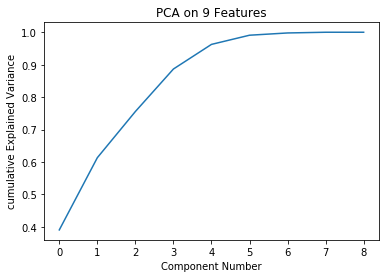

In [84]:
pca.n_components_
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Component Number')
plt.ylabel('cumulative Explained Variance')
plt.title('PCA on 9 Features')

We only use 5 features as that is all that is needed to represent the data.

In [85]:
pca = PCA(n_components=5)
final = pca.fit_transform(y_norm)
pca.n_components_

5

The training and testing data is transformed to only contain the 5 features.

In [86]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)


#### Regression Models

The code below fits the training data to a linear regression model by attempting to minimize error. The trained model is then used to predict how much money a movie makes with the testing data.

In [87]:
linear = linear_model.LinearRegression()
linear.fit(X_train, y_train)
prediction = linear.predict(X_test)
X_train

array([[-2.97e-01,  1.95e+00,  1.05e+00,  1.51e-01,  1.80e-01],
       [ 1.93e-01,  3.46e+00, -2.17e-01, -4.02e-02,  2.65e-01],
       [-6.59e-01,  9.75e-02, -1.08e+00, -1.67e-02,  3.18e-02],
       ...,
       [ 5.81e+00, -1.65e+00,  1.79e-01,  1.32e-01,  7.65e-01],
       [-9.26e-01, -5.37e-01, -8.59e-01,  6.29e-01,  6.91e-02],
       [ 1.34e+00,  1.81e-01, -8.01e-01, -8.74e-02, -3.80e-03]])

The below code shows the percentage of correct predictions as we increase the bounds of the accuracy of the model. When the bounds are around 100000 dollars, the percentage of correct predictions is approximately 0%. When the bounds are at 100000000 dollars, the percentage of correct predictions is approximately 90%.

C:\Users\zach\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\zach\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in longlong_scalars
  


Text(0.5,1,'Percentage of Correct Predictions as the Accuracy Boundary Increase')

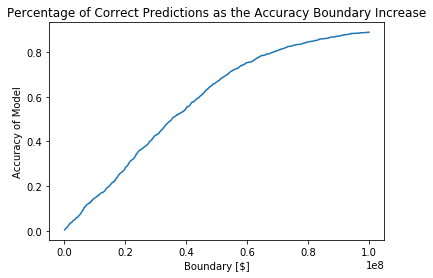

In [88]:
testValues = y_test.as_matrix(columns = None)
lists =[]
numcorrect = []
boundary = []
i = 0
correct = 0
j = 0
for j in range(100000, 100000000, 100000):
    i = 0
    correct = 0
    for i in range(len(prediction)):
        if -j <= (prediction[i] - testValues[i]) and (prediction[i] - testValues[i]) <= j:
            correct += 1
            lists.append(j/testValues[i])
        i += 1
    numcorrect.append(correct/i)
    boundary.append(j)

plt.plot(boundary, numcorrect)
plt.xlabel('Boundary [$]')
plt.ylabel('Accuracy of Model')
plt.title('Percentage of Correct Predictions as the Accuracy Boundary Increase')

From the above graph, it can be seen that the linear regression model performs very badly for this data when trying to predict how much money a movie will earn at the box office. Another model will be used to see if an improvement can be made on the results. A regression based neural network will be used as it will be better at converging to a result.

**Warning, the following code may take 20 minutes to perform**

As shown below, a GridSearchCV was used to determine the best parameters for the model. It was found that the following parameters produced the best results. Many different parameters were used but most converged to the same anser which can be seen later.

- hidden_layer_sizes = [50,50,50,50]
- batch_size = 200
- learning_rate = 'adaptive'
- alpha = 0.00001
- solver = 'adam'
- max_iter = 10000
- activation = 'relu'

# **HAVE TO WORK ON HYPERPARAMETERS STILL TO GET BEST RESULTS**

In [ ]:
mlp = MLPRegressor(max_iter=5000)
parameters = {'hidden_layer_sizes':[(100,150,200),(20,50,50), (150,150,150,150,150), (20,), (20,20,20,20,20,20,20,20), (20,20)], 
              'activation':('tanh', 'tanh')}
clf = RandomizedSearchCV(mlp, parameters, verbose=100, n_jobs=-1)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Pickling array (shape=(15633, 5), dtype=float64).
Pickling array (shape=(15633,), dtype=int64).
Pickling array (shape=(15633,), dtype=int64).
Pickling array (shape=(15633,), dtype=int64).
Pickling array (shape=(10422,), dtype=int32).
Pickling array (shape=(5211,), dtype=int32).
Pickling array (shape=(15633, 5), dtype=float64).
Pickling array (shape=(15633,), dtype=int64).
Pickling array (shape=(15633,), dtype=int64).
Pickling array (shape=(15633,), dtype=int64).
Pickling array (shape=(10422,), dtype=int32).
Pickling array (shape=(5211,), dtype=int32).
Pickling array (shape=(15633, 5), dtype=float64).
Pickling array (shape=(15633,), dtype=int64).
Pickling array (shape=(15633,), dtype=int64).
Pickling array (shape=(15633,), dtype=int64).
Pickling array (shape=(10422,), dtype=int32).
Pickling array (shape=(5211,), dtype=int32).
Pickling array (shape=(15633, 5), dtype=float64).
Pickling array (shape=(15633,), dtype=int64).
Pickli

In [90]:
trainmlp = clf.best_estimator_
clf.best_estimator_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

The model is trained below. The loss is printed to show the result converging to an answer.

In [72]:
mlpmodel = trainmlp.fit(X_train, y_train)

The test data is then applied to the trained model. The test data was not used for the training so the test data will be the first time the model sees them.

In [73]:
mlpprediction = trainmlp.predict(X_test)

Again plot the accuracy of the model as the boundary (predicted money made +/- the boundary) increases. It shows a better result where at around +/- $10000000 of the actual money made, the predicted value was correct 25 percent of the time. It is not a great model but is a little better than the linear regression model where the same boundary returned an accuracy of 18 percent.

C:\Users\zach\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\zach\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in longlong_scalars
  from ipykernel import kernelapp as app


Text(0.5,1,'Percentage of Correct Prediction as the Accuracy Boundary Increase')

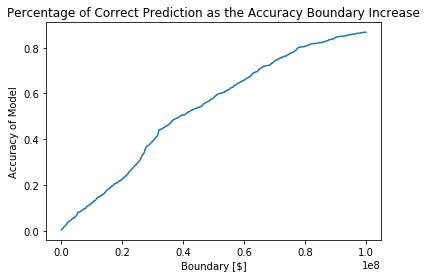

In [74]:

testValues = y_test.as_matrix(columns = None)
lists =[]
numcorrect = []
boundary = []
i = 0
correct = 0
j = 0
for j in range(100000, 100000000, 100000):
    i = 0
    correct = 0
    for i in range(len(mlpprediction)):
        if -j <= mlpprediction[i] - testValues[i] and (mlpprediction[i] - testValues[i]) <= j:
            correct += 1
            lists.append(j/testValues[i])
        i += 1
    numcorrect.append(correct/i)
    boundary.append(j)

plt.plot(boundary, numcorrect)
plt.xlabel('Boundary [$]')
plt.ylabel('Accuracy of Model')
plt.title('Percentage of Correct Prediction as the Accuracy Boundary Increase')

### Building Classification Model to Predict Oscar Wins

The next criteria of success that will be tracked is whether a movie will win an Oscar. This model will be simpler in that there are a limited number of classes. Since the most Oscars won by by a movie (for acting, directing and best picture win only) is 5. The classes will be split into 6 classes (based on number of Oscar wins).

The dependent variable is chosen to be the total number of Oscar wins in terms of acting, directing and best picture win (as these are seen as the most prestigious awards).

In [39]:
X = df['Total Oscar Wins']

The data is split between testing and training (90,10 split)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(y, X, test_size=0.1, random_state=1)

Once again the data is normalized/standardize in order to prevent any bias in weightings between features.

In [41]:
scaler = StandardScaler()
scaler.fit(X_train)

from sklearn.preprocessing import normalize

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_norm = normalize(y,axis=0)

A principle component analysis is performed below where the normalized data is used to determine which features are most important

In [42]:
pca = PCA()
final = pca.fit_transform(y_norm)
final.shape

(17370, 9)

The cdf for the PCA analysis can be seen below. It appears as though 95% of the covaraince is represented in only 5 features so the dimension of the data (number of features) will be reduced to 5.

Text(0.5,1,'PCA on 9 Features')

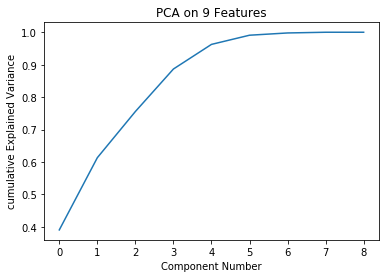

In [43]:
pca.n_components_
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Component Number')
plt.ylabel('cumulative Explained Variance')
plt.title('PCA on 9 Features')

In [44]:
pca = PCA(n_components=5)
final = pca.fit_transform(y_norm)
pca.n_components_

5

The training and test data is then transformed to be only the 5 most important features

In [45]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

#### Naive Bayes Classification Model

The first classification model used is the Naive Bayes model. This model assumesn conditional independence between every pair of features given the value of the class variable. more specifically a Gaussian Naive Bayes model is used.

The code below is used to train the model with the training data. Then the prediction of Oscar wins is found for the test data to see how well the model works. The accuracy and precision are found for the model to determine how well it classifys.

In [54]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average=None))
class_names = ('0 Oscars','1 Oscar','2 Oscars','3 Oscars','4 Oscars','5 Oscars')

Accuracy: 0.9004029936672424
Precision: [0.98780488 0.77556818 0.49618321 0.47058824 0.6        0.        ]
Recall: [0.95219436 0.875      0.60747664 0.22857143 0.5        0.        ]


The code below contains a function `plot_confusion_matrix` which takes in the predicted and actual labels for each movie and plots, in a visual way, how accurate each class was predicted. The normalized and non-normalized plots can be seen for the Gaussian Naive Bayes model below

Confusion matrix, without normalization
[[1215   41   19    1    0    0]
 [  15  273   23    1    0    0]
 [   0   38   65    4    0    0]
 [   0    0   24    8    2    1]
 [   0    0    0    2    3    1]
 [   0    0    0    1    0    0]]
Normalized confusion matrix
[[9.52e-01 3.21e-02 1.49e-02 7.84e-04 0.00e+00 0.00e+00]
 [4.81e-02 8.75e-01 7.37e-02 3.21e-03 0.00e+00 0.00e+00]
 [0.00e+00 3.55e-01 6.07e-01 3.74e-02 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 6.86e-01 2.29e-01 5.71e-02 2.86e-02]
 [0.00e+00 0.00e+00 0.00e+00 3.33e-01 5.00e-01 1.67e-01]
 [0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00]]


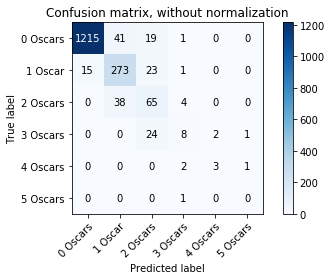

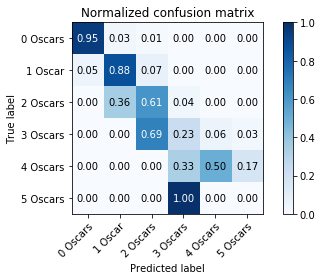

In [55]:
from sklearn import svm, datasets

from sklearn.metrics import confusion_matrix

# Got this function from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Support Vector Classification Model
To see if we can mprove on the previous results using a Naive Bayes model, a support vector machine is used. This model will be used to see if improvement can be made, specfically in non-linear classification.

The code below creates an SVC model and fits it to the training data.

In [56]:
from sklearn import svm
from sklearn import metrics
clf = svm.SVC(gamma=0.001, C=100., verbose=True)
clf.fit(X_train, y_train)

[LibSVM]

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

The model is then tested with the test data to predict Oscar wins. Accuracy and prcision of the model are found to determine if there are improvements to the previous Naive Bayes model.

In [57]:
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average=None))

Accuracy: 0.9988485895221646
Precision: [1. 1. 1. 1. 1. 1.]
Recall: [1.   0.99 1.   1.   1.   1.  ]


The resuts are then plotted in a confusion matrix.

Confusion matrix, without normalization
[[1276    0    0    0    0    0]
 [   2  310    0    0    0    0]
 [   0    0  107    0    0    0]
 [   0    0    0   35    0    0]
 [   0    0    0    0    6    0]
 [   0    0    0    0    0    1]]
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.  ]
 [0.01 0.99 0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   1.  ]]


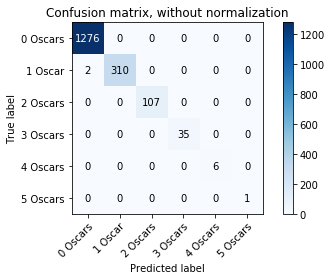

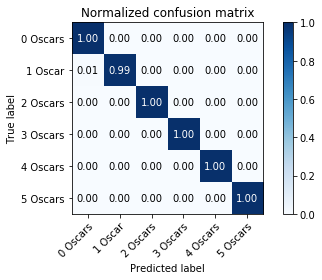

In [58]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Conclusion